In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import cv2
import skimage.morphology as skim_morph
import scipy.ndimage.measurements as scipy_im_measure
import pandas as pd
from scipy import signal
import math
import scipy.spatial.distance as scp_dist
import random
import scipy.ndimage as scp_nd

Problem 1: Hough Transform

Reference: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_gradients/py_gradients.html

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html

Reference: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

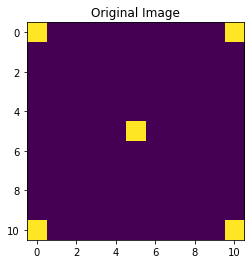

In [2]:
test = np.zeros((11,11))

test[0,0] = 1
test[0,-1] = 1
test[-1,0] = 1
test[-1,-1] = 1
test[5,5] = 1

plt.imshow(test)
plt.title('Original Image');

In [3]:
theta_rad = np.arange(-90,91)*np.pi*(1/180)
rho_axis = np.arange(-14,15)

In [4]:
ac = np.zeros((29, 181))

In [5]:
# looping through image
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        if(test[i][j]==1):
            rho = i*np.cos(theta_rad) + j*np.sin(theta_rad)
            
            # round rho
            rho_rounded = np.round_(rho).astype(int)
            
            # convert rad theta to deg theta
            theta_deg = (theta_rad * (180/np.pi)).astype(int)
            
            # increment accumulator
            ac[rho_rounded, theta_deg] = ac[rho_rounded, theta_deg] + 1
            

Rolling:

In [6]:
ax_horiz_roll = np.roll(ac, 90, axis = 1)
ax_vert_roll = np.roll(ax_horiz_roll, 14, axis = 0)

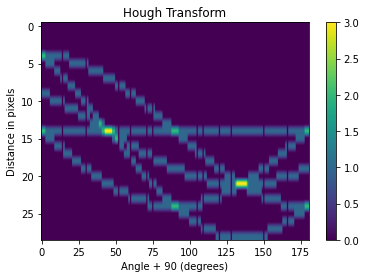

In [7]:
plt.imshow(ax_vert_roll, aspect = 'auto')
plt.title('Hough Transform')
plt.colorbar()
plt.xlabel('Angle + 90 (degrees)')
plt.ylabel('Distance in pixels');

b. Threshold the HT by looking for any (ρ, θ) cells that contains more than 2 votes then plot the corresponding lines in (x,y)-space on top of the original image.

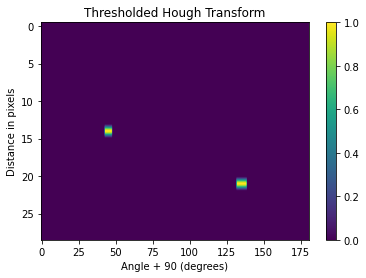

In [8]:
thresh_ht = np.where(ax_vert_roll>2,1,0)
plt.imshow(thresh_ht, aspect = 'auto')
plt.title('Thresholded Hough Transform')
plt.colorbar()
plt.xlabel('Angle + 90 (degrees)')
plt.ylabel('Distance in pixels');

In [9]:
# finding the indices of most votes

dist, angle = np.where(thresh_ht>0)

orig_dist = dist - 14
orig_angle = angle - 90



In [10]:
for i in range(orig_dist.shape[0]):

    rho_0, theta_0 = orig_dist[i], orig_angle[i]
    
    x = np.arange(11)
    
    y = np.floor((rho_0 - (x*np.cos(theta_0*(np.pi/180))))/(np.sin(theta_0*(np.pi/180)))).astype(int)
    
    test[x,y] = 1


Text(0.5, 1.0, 'Original Image with Lines')

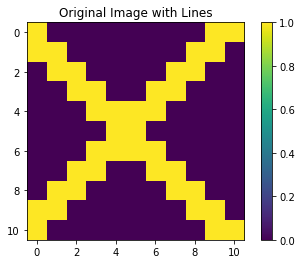

In [11]:
plt.imshow(test)
plt.colorbar()
plt.title('Original Image with Lines')

Part 3

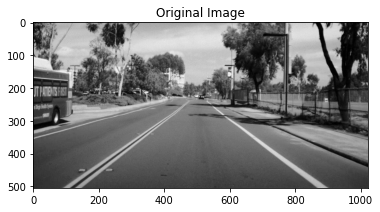

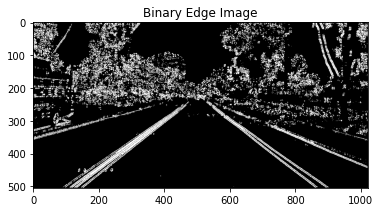

In [12]:
img = plt.imread('lane.png')
img = img[:,:,0]
plt.figure()
plt.imshow(img, cmap = 'gray');
plt.title('Original Image')

img_64_sobel = cv2.Sobel(img,cv2.CV_64F,1,1,ksize=7)
abs_sobel64f = np.abs(img_64_sobel)
img_thresh = np.uint8(abs_sobel64f)
ret3,th3 = cv2.threshold(img_thresh,0,1,cv2.THRESH_OTSU)
plt.figure()
plt.imshow(th3, cmap = 'gray');
plt.title('Binary Edge Image');

In [13]:
theta_rad_lane = np.arange(-90,91)*np.pi*(1/180)
rho_axis_lane = np.arange(-1140,1141)

In [14]:
ac_lane = np.zeros((2281, 181))

In [15]:
# looping through image
for i in range(th3.shape[0]):
    for j in range(th3.shape[1]):
        if(th3[i][j]==1):
            rho_lane = i*np.cos(theta_rad_lane) + j*np.sin(theta_rad_lane)
            
            # round rho
            rho_rounded_lane = np.round_(rho_lane).astype(int)
            
            # convert rad theta to deg theta
            theta_deg_lane = (theta_rad_lane * (180/np.pi)).astype(int)
            
            # increment accumulator
            ac_lane[rho_rounded_lane, theta_deg_lane] = ac_lane[rho_rounded_lane, theta_deg_lane] + 1
     

In [16]:
ax_horiz_roll = np.roll(ac_lane, 90, axis = 1)
ax_vert_roll = np.roll(ax_horiz_roll, 1140, axis = 0)

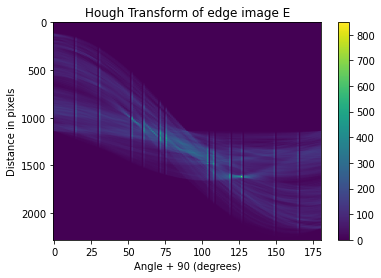

In [17]:
plt.imshow(ax_vert_roll, aspect = 'auto')
plt.title('Hough Transform of edge image E');
plt.colorbar()
plt.xlabel('Angle + 90 (degrees)')
plt.ylabel('Distance in pixels');

In [18]:
thresh_HT_lane = np.max(ax_vert_roll)*0.75

In [19]:
thresh_HT_lane_applied = np.where(ax_vert_roll>thresh_HT_lane, 1, 0)

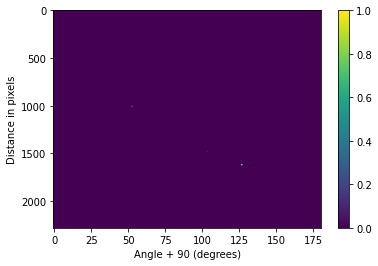

In [20]:
plt.imshow(thresh_HT_lane_applied, aspect = 'auto')
plt.colorbar()
plt.xlabel('Angle + 90 (degrees)')
plt.ylabel('Distance in pixels');

In [21]:
# plotting lines

dist_lane, angle_lane = np.where(thresh_HT_lane_applied>0)


orig_dist_lane = dist_lane - 1140
orig_angle_lane = angle_lane - 90

In [22]:
lane_copy = img

In [23]:
for i in range(orig_dist_lane.shape[0]):

    rho_0, theta_0 = orig_dist_lane[i], orig_angle_lane[i]
    
    x = np.arange(400)
    
    x = x[::-1]
    
    x = x[:300]
    
    y = np.floor((rho_0 - (x*np.cos(theta_0*(np.pi/180))))/(np.sin(theta_0*(np.pi/180)))).astype(int)
    
    lane_copy[x,y] = 1


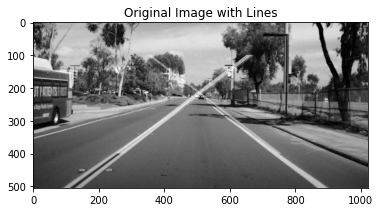

In [24]:
plt.imshow(lane_copy, cmap = 'gray')
plt.title('Original Image with Lines');

Part iv

In [25]:
# using the thresholded HT, we must rethreshold using a
# specified range of theta this time.

# the angles seem to be 37 and -37 degrees based on my
# output from the previous part of the problem

# so I will rethreshold so that only the angles -37 and 37 are
# allowed

In [26]:
print(orig_dist_lane)
print(orig_angle_lane)

[-136 -135 -133 -132  341  472  473  474  475  476  477  478  479  480
  481  482  485]
[-37 -37 -37 -37  14  37  37  37  37  37  37  37  37  37  37  37  37]


In [27]:
# from above observation, we should not allow index 4 of both
# distance array and angle array

new_dist_lane = np.delete(orig_dist_lane,4)
new_angle_lane = np.delete(orig_angle_lane,4)

#### Now the only angles are -37 and 37. These are the theta values I got for 2(iv).

In [28]:
new_angle_lane

array([-37, -37, -37, -37,  37,  37,  37,  37,  37,  37,  37,  37,  37,
        37,  37,  37])

In [29]:
# now rethresholding

lane_copy_new = img

for i in range(new_dist_lane.shape[0]):

    rho_0, theta_0 = new_dist_lane[i], new_angle_lane[i]
    
    x = np.arange(400)
    
    x = x[::-1]
    
    x = x[:300]
    
    y = np.floor((rho_0 - (x*np.cos(theta_0*(np.pi/180))))/(np.sin(theta_0*(np.pi/180)))).astype(int)
    
    lane_copy_new[x,y] = 1


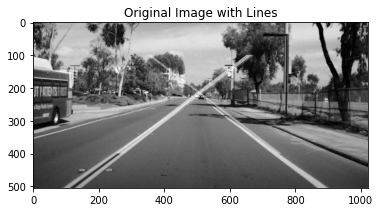

In [30]:
plt.imshow(lane_copy_new, cmap = 'gray')
plt.title('Original Image with Lines');

Problem 2: K Means Segmentation

In [31]:
def createDataset(im):
    return(im.reshape(-1).reshape(im.shape[0]*im.shape[1],3))

In [32]:
def new_centers(features, centers):

    # given features and centers, this calculates new centers

    dist_mat = scp_dist.cdist(features, centers) # calculating distance array

    # calculating idx
    idx = np.argmin(dist_mat, axis = 1) + 1 # calculating group


    all_1 = np.where(idx == 1)
    mean_1 = np.mean(features[all_1], axis = 0)

    all_2 = np.where(idx == 2)
    mean_2 = np.mean(features[all_2], axis = 0)

    all_3 = np.where(idx == 3)
    mean_3 = np.mean(features[all_3], axis = 0)

    all_4 = np.where(idx == 4)
    mean_4 = np.mean(features[all_4], axis = 0)

    all_5 = np.where(idx == 5)
    mean_5 = np.mean(features[all_5], axis = 0)

    all_6 = np.where(idx == 6)
    mean_6 = np.mean(features[all_6], axis = 0)

    all_7 = np.where(idx == 7)
    mean_7 = np.mean(features[all_7], axis = 0)


    # stack all means together to form new centers matrix
    centers2 = np.vstack((mean_1, mean_2, mean_3, mean_4, mean_5, mean_6, mean_7))
    
    return(centers2)

In [33]:
def kMeansCluster(features, centers):
    
    max_iter = 1000
    

    for i in tqdm(range(max_iter)):
        
        centers2 = new_centers(features, centers)
                
        if(np.array_equal(centers2, centers)):
            
            dist_mat = scp_dist.cdist(features, centers2)
            idx = np.argmin(dist_mat, axis = 1) + 1 # calculating group
            
            return(idx, centers2)
        else:
            centers = centers2
    
    # given new centers, calculate idx
    dist_mat = scp_dist.cdist(features, centers2)
    idx = np.argmin(dist_mat, axis = 1) + 1
    
    return(idx, centers2)

In [34]:
def centers_given_idx(features, idx):
    
    all_1 = np.where(idx == 1)
    mean_1 = np.mean(features[all_1], axis = 0)

    all_2 = np.where(idx == 2)
    mean_2 = np.mean(features[all_2], axis = 0)

    all_3 = np.where(idx == 3)
    mean_3 = np.mean(features[all_3], axis = 0)

    all_4 = np.where(idx == 4)
    mean_4 = np.mean(features[all_4], axis = 0)

    all_5 = np.where(idx == 5)
    mean_5 = np.mean(features[all_5], axis = 0)

    all_6 = np.where(idx == 6)
    mean_6 = np.mean(features[all_6], axis = 0)

    all_7 = np.where(idx == 7)
    mean_7 = np.mean(features[all_7], axis = 0)


    # stack all means together to form new centers matrix
    centers2 = np.vstack((mean_1, mean_2, mean_3, mean_4, mean_5, mean_6, mean_7))
    
    return centers2

In [35]:
def mapValues(im, idx):
    # find features
    features = createDataset(img)
    # calculate centers given idx and features
    centers2 = centers_given_idx(features, idx)
    
    # segment image
    
    features_new = features

    all_1 = np.where(idx==1)
    features_new[all_1] = centers2[0,:]

    all_2 = np.where(idx==2)
    features_new[all_2] = centers2[1,:]

    all_3 = np.where(idx==3)
    features_new[all_3] = centers2[2,:]

    all_4 = np.where(idx==4)
    features_new[all_4] = centers2[3,:]

    all_5 = np.where(idx==5)
    features_new[all_5] = centers2[4,:]

    all_6 = np.where(idx==6)
    features_new[all_6] = centers2[5,:]

    all_7 = np.where(idx==7)
    features_new[all_7] = centers2[6,:]

    seg_img = np.reshape(features_new, (img.shape[0],img.shape[1],3))
    
    return(seg_img)

In [36]:
# given image, segment it using k means

img = plt.imread('white-tower.png')


# step 1: calculate features given image



features = createDataset(img)

# step 2: initialize centers

random.seed(5)
nclusters = 7
idx = np.random.randint(0, features.shape[0], (nclusters, 1))
centers = features[idx, :]
centers = np.squeeze(centers)

# step 3: calculate new centers using 10000 iterations of k-means

idx, centers = kMeansCluster(features, centers)

# step 4: segment image using idx

seg_img = mapValues(img, idx)

  5%|▌         | 53/1000 [00:03<00:59, 15.92it/s]


Text(0.5, 1.0, 'Segmented Image')

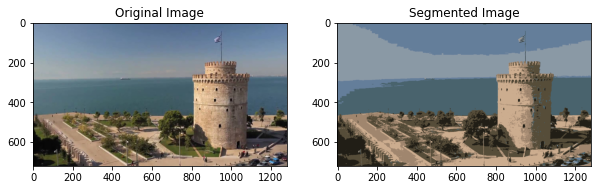

In [38]:
img = plt.imread('white-tower.png')

fig = plt.figure(figsize = [10,5])
ax1 = fig.add_subplot(121)
ax1.imshow(img)
ax1.set_title('Original Image')
ax2 = fig.add_subplot(122)
ax2.imshow(seg_img)
ax2.set_title('Segmented Image')

My centers after segmentation were:

In [40]:
centers

array([[0.54425454, 0.6000721 , 0.6505426 ],
       [0.33977142, 0.3024052 , 0.22497821],
       [0.80300707, 0.6790147 , 0.56182367],
       [0.62938166, 0.5276112 , 0.4348132 ],
       [0.13083686, 0.1179914 , 0.08717921],
       [0.28665406, 0.38855982, 0.42901593],
       [0.39597246, 0.49507087, 0.60606676]], dtype=float32)